- Dynamical Encoding Bow-tie architecture の進化シミュレーションを行う
- 多入力、多出力、1つの中間層を持つBow-tie構造から始める
- 入力にはさまざまなパターンが入る eg., 10011011
- ノードへの入力和が非線形活性化関数にかまされ出力される
- 中間層はさまざまなダイナミクスをしめす
- ダイナミクスと入力セットを関連づけたデータセットを作成
- データセットより入力を正しく予測できるか否かを適応度関数とする


### Evolutionary simulation of Dynamical Encoding 

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score 
from sklearn.metrics import mutual_info_score
import matplotlib.animation as animation
import random
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.simplefilter('ignore')

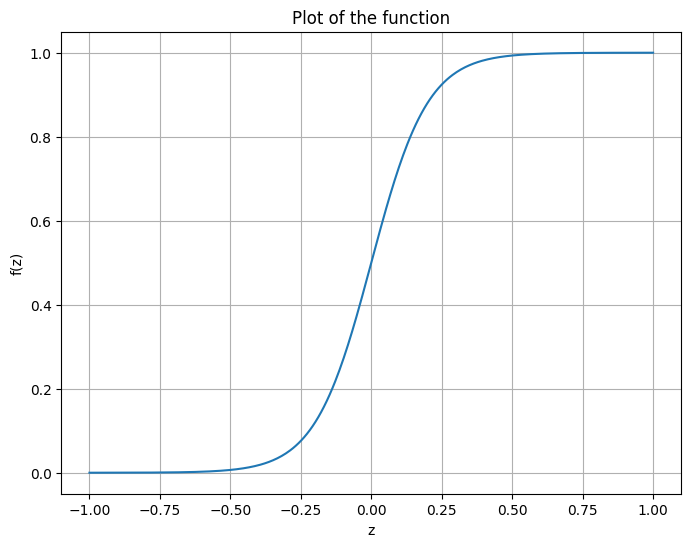

In [2]:
# Define parameters
n_hill = 2  # Example value, change as needed
x = 1       # Example value, change as needed
beta = -10
Ka = 0.5
# Define the function
def f(z, n_hill, d_rate, x):
    return (z**n_hill / (Ka**n_hill + z**n_hill))

def f(z, _, __, ___):
    return 1.0/(1.0+np.exp(beta*z))


# Generate values for z
z = np.linspace(-1, 1, 400)

# Compute function values
y = f(z, n_hill, 1, x)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(z, y)
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('Plot of the function')
plt.grid(True)
plt.show()

In [3]:
# position
theta = np.linspace(0, 2 * np.pi, 6)[:-1]  # 0から2πまでを5分割（頂点の数）
r = 0.2  # 半径
x = r * np.sin(theta + np.pi)  # x座標
y = r * np.cos(theta + np.pi)  # y座標
pos_net = {(4-i): (x[i], y[i]) for i in range(5)}  # ノード位置を設定

def write_network(most_fit, folder, Gen):
    adj_matrix = most_fit.get_network()*10
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    edge_colors = ['skyblue' if G[u][v]['weight'] < 0 else 'red' for u, v in G.edges]
    edge_widths = [abs(G[u][v]['weight']) for u, v in G.edges]
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='grey', edge_color=edge_colors, node_size=2000, arrowstyle='->', arrowsize=10, width=edge_widths)
    #nx.attr(label= f"Gen:{Gen}, Fitness: {np.round(most_fit.fitness, 4)}")
    plt.savefig(f"{folder}/ID{most_fit.id}_{Gen}.png")



def write_dynamics(most_fit, folder, Gen):
    plt.cla()
    fig = plt.figure(figsize=(5,4))
    AX = fig.add_subplot(1, 1, 1)
    axins = inset_axes(AX, width="40%", height="30%", loc='right')
    encoder_response = get_encoder_responses(perturb_inputs, most_fit)
    restricted_encoder_response = encoder_response[:,ReferenceTime[0]:ReferenceTime[1]]
    for i in range(n_sample):
        AX.plot(encoder_response[i,], colors[i], alpha = 1/(i%10+1))
        axins.plot(restricted_encoder_response[i,], colors[i], alpha = 1/(i%10+1))
    AX.set_title(f"Gen:{Gen}, Fitness: {np.round(most_fit.fitness, 4)}")
    AX.set_ylim(0,0.28)
    axins.set_ylim(0,0.28)
    plt.savefig(f"{folder}/ID{most_fit.id}_Gen{Gen}.png")



In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score 
from sklearn.metrics import mutual_info_score
import matplotlib.animation as animation
import random
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.simplefilter('ignore')

Num_Net = 10
Num_Gene = 5         
Num_Receptor = 2 # The first {Num_Receptor} genes are receptors.
HubGeneID = Num_Gene-1 # The last gene is output.
Num_NoisePattern = 10

G_max = 100
beta = -10   #発現制御の鋭さ
dt = 1        
t_end=100         
times=np.arange(0,t_end,dt) 
steady_times=np.arange(0,50,0.1) 
times=np.arange(0,t_end,dt) 
ReferenceTime = [0,int(10/dt)]
print(f"Decoder references from {ReferenceTime[0]} to {ReferenceTime[1]} step of Hub dynamics.")

n_hill = 2

#Define indivisdual instance
class Cell:

    def __init__(self, id):
        self.adjmatrix = np.random.normal(0, 0.01, (Num_Gene, Num_Gene))
        self.fitness = 0
        self.drate = np.random.normal(1, 0.01, (Num_Gene))
        self.id = id

    def get_network(self):
        return self.adjmatrix

    def get_drate(self):
        return self.drate

    def get_fitness(self):
        return self.fitness

    def get_theta(self):
        return self.theta

    def set_network(self, adjmatrix):
        self.adjmatrix = adjmatrix

    def set_fitness(self, fitness):
        self.fitness = fitness

    def set_drate(self, drate):
        drate[drate < 0] = 0
        self.drate = drate

    def set_theta(self):
        self.theta = theta





n_hill = 2
Ka = 0.5
# hill function
#負の値を許容したいのでステップ関数を使った方が良い？
def get_dx(x, W, d_rate, x_input):
    z = np.dot(W, x) + x_input
    #step func 
    dx = z**n_hill / (Ka + z**n_hill) - d_rate * x
    return dx
"""
#step function
d_rate = 1
def get_dx(x, W, theta, x_input):
    z = np.dot(W,x)- theta + x_input
    dx=1.0/(1.0+np.exp(beta*z)) - d_rate * x
    return dx
"""

# ルンゲクッタ法 (RK4)
def solve_dx(W, d_rate, x_input_arr, x0, t_end):
    times = np.arange(0,t_end,dt) 
    x_values = np.zeros((len(times), len(x0)))
    x_values[0] = x0 + x_input_arr[0]
    x_values[0][x_values[0] < 0] = 0
    for i in range(1, len(times)):
        t = times[i-1]
        x = x_values[i-1]
        k1 = dt * get_dx(x, W, d_rate, x_input_arr[i])
        k2 = dt * get_dx(x + 0.5 * k1, W, d_rate, x_input_arr[i])
        k3 = dt * get_dx(x + 0.5 * k2, W, d_rate, x_input_arr[i])
        k4 = dt * get_dx(x + k3, W, d_rate, x_input_arr[i])
        x_values[i] = x + (k1 + 2*k2 + 2*k3 + k4) / 6
        x_values[i][x_values[i] < 0] = 0
    return x_values
    




def get_encoder_responses(inputs_list, Outputnoise, cell):

    W = cell.get_network()
    d_rate = cell.get_drate()
    steady_state = solve_dx(W, d_rate, zeros_input, np.zeros(Num_Gene), 50)[-1]
    #print("steady_state")
    #print(steady_state)
    pattern1_out = np.array([solve_dx(W, d_rate, noisy_input, steady_state, t_end) for noisy_input in inputs_list[0]])
    pattern2_out = np.array([solve_dx(W, d_rate, noisy_input, steady_state, t_end) for noisy_input in inputs_list[1]])
    pattern3_out = np.array([solve_dx(W, d_rate, noisy_input, steady_state, t_end) for noisy_input in inputs_list[2]])
    pattern4_out = np.array([solve_dx(W, d_rate, noisy_input, steady_state, t_end) for noisy_input in inputs_list[3]])
    pattern1_hubout = pattern1_out[0:,0:,HubGeneID] + np.random.normal(0, Outputnoise, (Num_NoisePattern, len(times)))
    pattern2_hubout = pattern2_out[0:,0:,HubGeneID] + np.random.normal(0, Outputnoise, (Num_NoisePattern, len(times)))
    pattern3_hubout = pattern3_out[0:,0:,HubGeneID] + np.random.normal(0, Outputnoise, (Num_NoisePattern, len(times)))
    pattern4_hubout = pattern4_out[0:,0:,HubGeneID] + np.random.normal(0, Outputnoise, (Num_NoisePattern, len(times)))
    return np.vstack((pattern1_hubout, pattern2_hubout, pattern3_hubout, pattern4_hubout))

def get_decoder_responses(encoder_dynamics):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(encoder_dynamics)
    kmeans = KMeans(n_clusters = Num_InputPattern, random_state=42)
    predicted_labels = kmeans.fit_predict(scaled)
    return predicted_labels

def evaluation(cell, inputs_list, true_labels, Outputnoise):
    encoder_responses = get_encoder_responses(inputs_list, Outputnoise, cell)
    restricted_encoder_responses = encoder_responses[:,ReferenceTime[0]:ReferenceTime[1]]
    predicted_labels = get_decoder_responses(restricted_encoder_responses)
    ami = mutual_info_score(true_labels, predicted_labels)
    return ami

def mutate(Cell):
    mutation_rate = 0.2
    bitmask = np.where(np.random.uniform(0, 1, (Num_Gene, Num_Gene))  < mutation_rate, 1, 0)
    noise_matrix = np.random.normal(0, 0.1, (Num_Gene, Num_Gene))
    mutated_net = Cell.get_network() + noise_matrix*bitmask
   
    bitmask = np.where(np.random.uniform(0, 1, Num_Gene)  < mutation_rate, 1, 0)
    noise = np.random.normal(0, 0.1, Num_Gene)
    mutated_drate = Cell.get_drate() + noise*bitmask
    Cell.set_network(mutated_net)
    Cell.set_drate(mutated_drate)
    return Cell


def select(population, tournament_size):    #Tournament selection
    tournament_groups = [random.sample(population, tournament_size) for i in range(Num_Net)]
    selected = [sorted(tournament_group, reverse=True, key=lambda u: u.fitness)[0] for tournament_group in tournament_groups]
    return selected


Net_IMGs=[]
Dyna_IMGs=[]
def evolution(inputs_list, Duration, Outputnoise, write_result=False):  

    # create cell instances
    Cell_group = [Cell(_id) for _id in range(Num_Net)]
    [cell.set_fitness(evaluation(cell, inputs_list, true_labels, Outputnoise)) for cell in Cell_group]
    ave_fit = np.zeros(G_max)
    for g in np.arange(G_max):
        
        # calculate fitness for each cell
    
        ave_fit[g] = np.mean([cell.get_fitness() for cell in Cell_group])
        print(f"Gen{g}, average fitness:{ave_fit[g]}")        
        print("update fitness")

        most_fitted = sorted(Cell_group, reverse=True, key=lambda u: u.fitness)[0]

        if write_result:
            print(most_fitted.id)
            [write_network(cell, "tmp_net5", g) for cell in Cell_group]
            [write_dynamics(cell, "tmp_dyna5", g) for cell in Cell_group]

        if abs(ave_fit[g] - max_fit) < 1e-7:
            print("saturated")
            return Cell_group, ave_fit[0:g+1], Net_IMGs, Dyna_IMGs
        
        
        print("===Alpha profile===")
        print(most_fitted.get_network())
        print(most_fitted.get_drate())
        print(most_fitted.get_fitness())
        print([cell.id for cell in Cell_group])
        print("===================")

        # increase
        print("increase & mutation")
        DCell_group = Cell_group.copy()
        #mutation
        DCell_group = [mutate(cell) for cell in DCell_group]
        [cell.set_fitness(evaluation(cell, inputs_list, true_labels)) for cell in DCell_group]
        #print(np.mean([cell.get_fitness() for cell in DCell_group]))
        
        # selection
        print("selection")
        Mixed_group = Cell_group + DCell_group
        Selected_group = sorted(Mixed_group, reverse=True, key=lambda u: u.fitness)[0:Num_Net]
        #Cell_group = select(Mixed_group, 4)
        Cell_group = Selected_group.copy()

    return Cell_group, ave_fit, Net_IMGs, Dyna_IMGs

input= np.zeros((3,5))

Num_InputPattern= 4
input_filter = [1,1,0,0,0]
input_pattern1 = [[[0,1,0,0,0] + np.random.normal(0,0.01, 5)*input_filter for _ in range(len(times))] for _ in range(Num_NoisePattern)]
input_pattern2 = [[[1,1,0,0,0] + np.random.normal(0,0.01, 5)*input_filter for _ in range(len(times))] for _ in range(Num_NoisePattern)]
input_pattern3 = [[[1,0,0,0,0] + np.random.normal(0,0.01, 5)*input_filter for _ in range(len(times))] for _ in range(Num_NoisePattern)]
input_pattern4 = [[[0,0,0,0,0] + np.random.normal(0,0.01, 5)*input_filter for _ in range(len(times))] for _ in range(Num_NoisePattern)]
perturb_inputs = [input_pattern1, input_pattern2, input_pattern3, input_pattern4]
zeros_input = np.zeros((len(times), 5))

print("input pattern (num_gene x input pattern\n")

true_labels = np.repeat(list(range(Num_InputPattern)), Num_NoisePattern)
max_fit = mutual_info_score(true_labels, true_labels)
print("max", max_fit)

#result = evolution(perturb_inputs, write_result=False)

Decoder references from 0 to 10 step of Hub dynamics.
input pattern (num_gene x input pattern

max 1.3862943611198904


In [6]:
"""
from PIL import Image
image_files = [f'tmp_dyna5/ID3_Gen{i}.png' for i in range(12)]  # ID4_Gen0.pngからID4_Gen5.pngまで
images = [Image.open(image) for image in image_files]
images[0].save('dyna_evo_ID3.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)

image_files = [f'tmp_net5/ID3_{i}.png' for i in range(12)]  # ID4_Gen0.pngからID4_Gen5.pngまで
images = [Image.open(image) for image in image_files]
images[0].save('net_evo_ID3.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)
"""

"\nfrom PIL import Image\nimage_files = [f'tmp_dyna5/ID3_Gen{i}.png' for i in range(12)]  # ID4_Gen0.pngからID4_Gen5.pngまで\nimages = [Image.open(image) for image in image_files]\nimages[0].save('dyna_evo_ID3.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)\n\nimage_files = [f'tmp_net5/ID3_{i}.png' for i in range(12)]  # ID4_Gen0.pngからID4_Gen5.pngまで\nimages = [Image.open(image) for image in image_files]\nimages[0].save('net_evo_ID3.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)\n"

### Fitness plot

In [6]:
fitness = result[1]
plt.figure(figsize=(6, 4))
plt.plot(fitness)
plt.xlabel("Generation")        

plt.ylabel("Mean itness")     
plt.show()

NameError: name 'result' is not defined

In [374]:
highest_fitness = np.max([cell.get_fitness() for cell in result[0]])
print(highest_fitness)
highest_cells = [cell for cell in result[0] if cell.get_fitness() >= highest_fitness]
print(len(highest_cells))
#hcell_dynamics = [tc_timecourse_calc(hcell, gene_input, test_mode = True, reft=[0,len(times)]) for hcell in highest_cells]
#hcell_fitness = [tc_fitness_calc(hcell, gene_input, test_mode = False) for hcell in highest_cells]

1.3862943611198904
20


### 性能可視化

Encoder response shape: (40, 100)
Restricted: (40, 10)
Predicted label:
[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 1]
True label:
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]
Mutual information:
1.3862943611198904


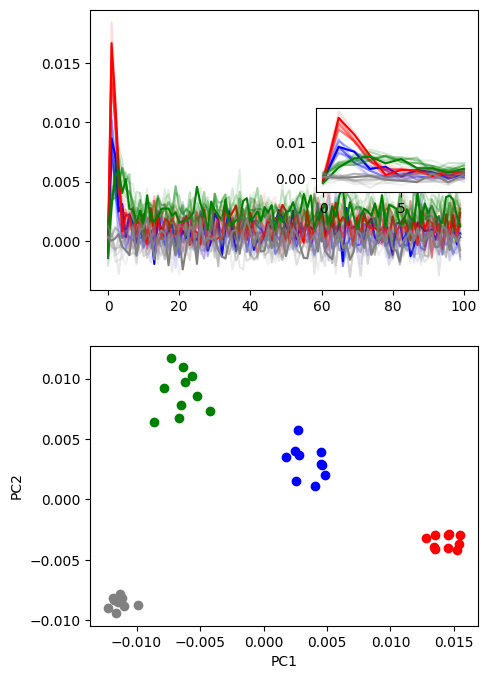

In [377]:
colors = np.repeat(["blue","red", "green", "grey"],10)
ID = 1
n_sample = Num_InputPattern*Num_NoisePattern


fig = plt.figure(figsize=(5,8))
AX[0] = fig.add_subplot(2, 1, 1)
AX[1] = fig.add_subplot(2, 1, 2)

axins = inset_axes(AX[0], width="40%", height="30%", loc='right')
encoder_response = get_encoder_responses(perturb_inputs, result[0][0])
restricted_encoder_response = encoder_response[:,ReferenceTime[0]:ReferenceTime[1]]
print(f"Encoder response shape: {encoder_response.shape}")
print(f"Restricted: {restricted_encoder_response.shape}")
for i in range(n_sample):
    AX[0].plot(encoder_response[i,], colors[i], alpha = 1/(i%10+1))
    axins.plot(restricted_encoder_response[i,], colors[i], alpha = 1/(i%10+1))

predicted_labels = get_decoder_responses(restricted_encoder_response)
print(f"Predicted label:\n{predicted_labels}")
print(f"True label:\n{true_labels}")
print(f"Mutual information:\n{mutual_info_score(true_labels, predicted_labels)}")


pca = PCA(n_components=2)
principal_components = pca.fit_transform(encoder_response)
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]
for label in np.unique(predicted_labels):
    AX[1].scatter(pc1[predicted_labels == label], pc2[predicted_labels == label], label=f'Cluster {label}', color=colors[label*10])



AX[1].set_xlabel('PC1')
AX[1].set_ylabel('PC2')

fig.show()

In [81]:
write_dynamics(most_fit)

1.3862943611198904

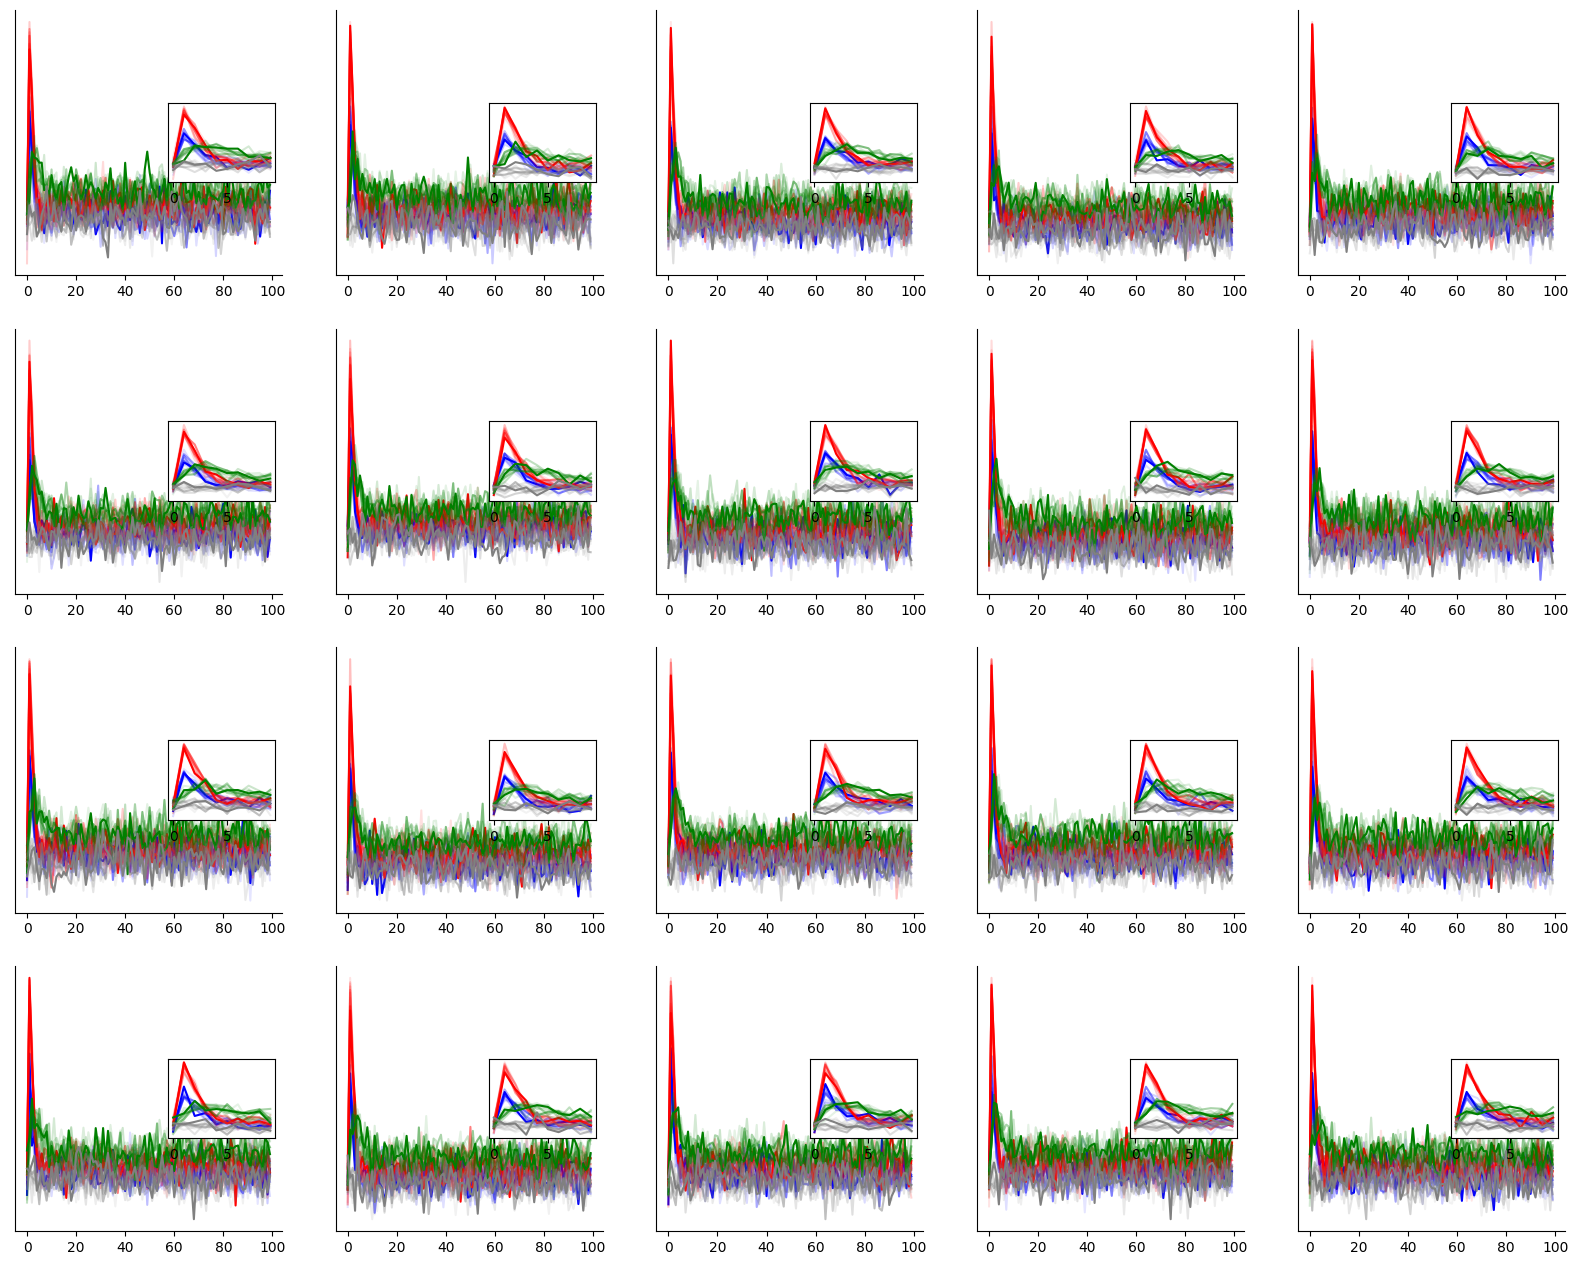

In [378]:
colors = np.repeat(["blue","red", "green", "grey"],10)
ID = 1
n_sample = Num_InputPattern*Num_NoisePattern

AX = [0]*Num_Net
fig = plt.figure(figsize=(20,20))

for ID in range(Num_Net):
    AX[ID] = fig.add_subplot(5, 5, ID+1)
    axins = inset_axes(AX[ID], width="40%", height="30%", loc='right')
    encoder_response = get_encoder_responses(perturb_inputs, result[0][ID])
    restricted_encoder_response = encoder_response[:,ReferenceTime[0]:ReferenceTime[1]]
    for i in range(n_sample):
        AX[ID].plot(encoder_response[i,], colors[i], alpha = 1/(i%10+1))
        axins.plot(restricted_encoder_response[i,], colors[i], alpha = 1/(i%10+1))
    AX[ID].spines['top'].set_visible(False)
    AX[ID].spines['right'].set_visible(False)
    AX[ID].set_yticks([])
    axins.set_yticks([])
    axins.set_yticks([])
    #predicted_labels = get_decoder_responses(restricted_encoder_response)
    

fig.show()

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

# position
theta = np.linspace(0, 2 * np.pi, 6)[:-1]  # 0から2πまでを5分割（頂点の数）
r = 0.2  # 半径
x = r * np.sin(theta + np.pi)  # x座標
y = r * np.cos(theta + np.pi)  # y座標
pos = {(4-i): (x[i], y[i]) for i in range(5)}  # ノード位置を設定
print(pos)

# write network
most_fit = highest_cells[3]#sorted(result[0], reverse=True, key=lambda u: u.fitness)[0]
print(most_fit.fitness)
adj_matrix = most_fit.get_network()*3
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
#print(G.edges)
edge_colors = ['skyblue' if G[u][v]['weight'] < 0 else 'red' for u, v in G.edges]
edge_widths = [abs(G[u][v]['weight']) for u, v in G.edges]

# グラフの描画
plt.figure(figsize=(8, 6))
#pos = nx.spring_layout(G)
print(pos)
nx.draw(G, pos, with_labels=True, node_color='grey', edge_color=edge_colors, node_size=2000, arrowstyle='->', arrowsize=10, width=edge_widths)
#plt.title(f"Receptor: {list(range(Num_Receptor))}, Output: {[HubGeneID]}")
plt.title(f"Fitness: {np.round(most_fit.fitness, 4)}")


{4: (2.4492935982947065e-17, -0.2), 3: (-0.1902113032590307, -0.061803398874989514), 2: (-0.11755705045849466, 0.16180339887498948), 1: (0.11755705045849459, 0.1618033988749895), 0: (0.19021130325903074, -0.061803398874989424)}


NameError: name 'highest_cells' is not defined

# Encoder characteristic 

> DynamicalEncoding_HPC.py で生成したpickle file の解析をこちらで行う

[<__main__.Cell object at 0x154aac5b0>, <__main__.Cell object at 0x15486e460>, <__main__.Cell object at 0x15486e760>, <__main__.Cell object at 0x15486eb50>, None, <__main__.Cell object at 0x15486ef70>, <__main__.Cell object at 0x15486e610>, <__main__.Cell object at 0x15486efd0>, <__main__.Cell object at 0x15486eeb0>, <__main__.Cell object at 0x15486e370>]
1.3862943611198904
[[ 0.135 -0.22  -1.197  1.075 -2.914]
 [ 0.346 -0.165 -0.954  0.348  2.987]
 [-1.129  1.546  0.735 -1.298  2.107]
 [-1.827 -2.581 -1.05   3.202 -1.081]
 [-1.18   0.022  1.002 -1.411 -1.494]]
[1.246 0.632 3.363 1.696 1.532]


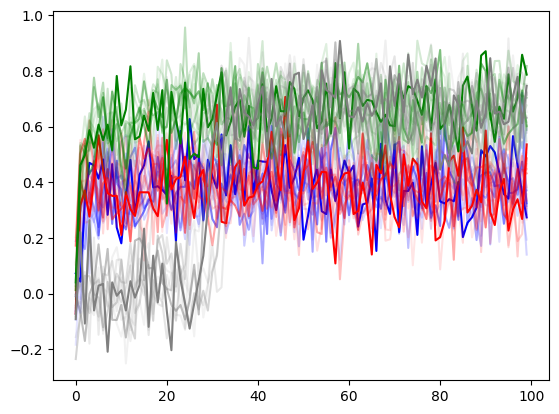

In [23]:
import pickle

with open(f'perturb_inputs.pickle', mode='rb') as f:
    perturb_inputs = pickle.load(f)

filename = "DynaEnc_10_1over10.pickle"
with open(f'DynaEncResult2/{filename}', mode='rb') as f:
    result = pickle.load(f)

print(result)
i = 0
print(result[i].fitness)
print(np.round(result[i].get_network(),3))
print(np.round(result[i].get_drate(),3))
encoder_response = get_encoder_responses(perturb_inputs, 0.1, result[i])

colors = np.repeat(["blue","red", "green", "grey"],10)
for i in range(40):
    plt.plot(encoder_response[i,], colors[i], alpha = 1/(i%10+1))

Encoder response shape: (40, 100)
Restricted: (40, 10)
Predicted label:
[0 0 0 2 0 0 0 2 0 0 2 2 0 2 0 2 0 0 2 2 3 3 3 3 3 3 3 2 3 3 1 1 1 1 1 1 1
 1 1 1]
True label:
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]
Mutual information:
0.7245112497836532


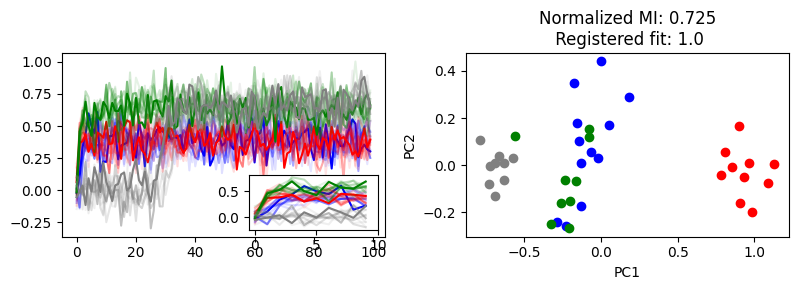

In [134]:
import pickle

with open(f'perturb_inputs.pickle', mode='rb') as f:
    perturb_inputs = pickle.load(f)
tar = 0
sigma = 1
duration = 10
filename = f"DynaEnc_{duration}_{sigma}over10.pickle"
with open(f'DynaEncResult2/{filename}', mode='rb') as f:
    result = pickle.load(f)

colors = np.repeat(["blue","red", "green", "grey"],10)
n_sample = Num_InputPattern*Num_NoisePattern


fig = plt.figure(figsize=(8,3))
AX = [fig.add_subplot(1, 2, i) for i in range(1,3)]


axins = inset_axes(AX[0], width="40%", height="30%", loc='lower right')
encoder_response = get_encoder_responses(perturb_inputs, sigma/10, result[tar])
restricted_encoder_response = encoder_response[:,0:duration]
print(f"Encoder response shape: {encoder_response.shape}")
print(f"Restricted: {restricted_encoder_response.shape}")
for i in range(n_sample):
    AX[0].plot(encoder_response[i,], colors[i], alpha = 1/(i%10+1))
    axins.plot(restricted_encoder_response[i,], colors[i], alpha = 1/(i%10+1))
axins.set_xlim(-0.5, duration)

predicted_labels = get_decoder_responses(restricted_encoder_response)
print(f"Predicted label:\n{predicted_labels}")
print(f"True label:\n{true_labels}")
score = mutual_info_score(true_labels, predicted_labels)/max_fit
print(f"Mutual information:\n{score}")


pca = PCA(n_components=3)
principal_components = pca.fit_transform(restricted_encoder_response)
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]
for label in np.unique(predicted_labels):
    AX[1].scatter(pc1[predicted_labels == label], pc2[predicted_labels == label], label=f'Cluster {label}', color=colors[label*10])
AX[1].set_xlabel('PC1')
AX[1].set_ylabel('PC2')
AX[1].set_title(f'Normalized MI: {np.round(score,3)}\n Registered fit: {np.round(result[tar].fitness/max_fit,3)}')


fig.tight_layout()

fig.show()

In [15]:
import pickle

with open(f'perturb_inputs.pickle', mode='rb') as f:
    perturb_inputs = pickle.load(f)

def wave_type_categorizer(cell, sigma):
    encoder_response = get_encoder_responses(perturb_inputs, sigma, cell)
    result_arr = 0
    for i in range(0,40):
        #fig = plt.figure(figsize=(8,2))
        #ax = [fig.add_subplot(1,2,ix) for ix in range(1,3)]
        #ax[0].plot(encoder_response[i,],color=colors[i])
        fk = np.fft.fft(encoder_response[i,])
        N = len(encoder_response[i,])
        freq = np.fft.fftfreq(N,d=1)
        maxval = max(encoder_response[i,])

        endval = encoder_response[i,-1]

        if max(np.abs(fk[1:int(N/2)])) > 20:
            # oscilliation
            result_arr += 1
            continue
        if maxval-endval > 2*sigma:
            # adaptation
            result_arr += 1
            continue
        else:
            continue
    return result_arr




duration_arr = list(range(10,110,10))
sigma10_arr = list(range(1,2,1))
FITNESS_ARR = np.zeros((len(duration_arr),len(sigma10_arr)))
PHASE_FIGURE_ARR = np.zeros((len(duration_arr),len(sigma10_arr)))
print(sigma10_arr)
print(duration_arr)
for di in range(len(duration_arr)):
    duration = duration_arr[di]
    for si in range(len(sigma10_arr)):
        sigma10 = sigma10_arr[si]
        print(f"duration:{duration}, sigma10: {sigma10}")
        if True:
            filename = f"DynaEnc_{duration}_{sigma10}over10.pickle"
            print(filename)
            with open(f'DynaEncResult2/{filename}', mode='rb') as f:
                result = pickle.load(f)
            #filter out none
            result = [result_ for result_ in result if result_ is not None]
            print(f"saturated run:{len(result)}")
    
            sigma = sigma10/10
            FITNESS_ARR[di, si] = np.mean([result[i].fitness for i in range(len(result))])
            PHASE_FIGURE_ARR[di, si] = np.mean([wave_type_categorizer(result[i], sigma)/40 for i in  range(len(result))])
            print(PHASE_FIGURE_ARR[di, si])
            print(FITNESS_ARR[di, si])

        else:
            print("file not fonud")
            PHASE_FIGURE_ARR[di, si] = 0
            FITNESS_ARR[di, si] = 0


[1]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
duration:10, sigma10: 1
DynaEnc_10_1over10.pickle
saturated run:9
0.7388888888888889
1.3862943611198904
duration:20, sigma10: 1
DynaEnc_20_1over10.pickle
saturated run:10
0.7175
1.3862943611198904
duration:30, sigma10: 1
DynaEnc_30_1over10.pickle
saturated run:8
0.73125
1.3862943611198904
duration:40, sigma10: 1
DynaEnc_40_1over10.pickle
saturated run:9
0.7222222222222222
1.3862943611198904
duration:50, sigma10: 1
DynaEnc_50_1over10.pickle
saturated run:9
0.725
1.3862943611198904
duration:60, sigma10: 1
DynaEnc_60_1over10.pickle
saturated run:10
0.6524999999999999
1.3862943611198904
duration:70, sigma10: 1
DynaEnc_70_1over10.pickle
saturated run:9
0.7222222222222222
1.3862943611198904
duration:80, sigma10: 1
DynaEnc_80_1over10.pickle
saturated run:10
0.71
1.3862943611198904
duration:90, sigma10: 1
DynaEnc_90_1over10.pickle
saturated run:9
0.686111111111111
1.3862943611198904
duration:100, sigma10: 1
DynaEnc_100_1over10.pickle
saturated run:

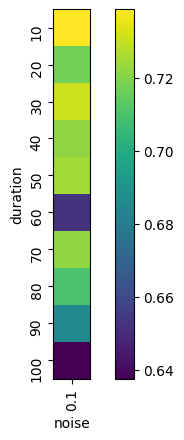

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [17]:
"""
PHASE_FIGURE_ARR = [[]]
"""


[]
fig, ax = plt.subplots()
im = ax.imshow(PHASE_FIGURE_ARR)
ax.set_yticks(list(range(len(duration_arr))))
ax.set_xticks(list(range(len(sigma10_arr))))
ax.set_yticklabels(duration_arr,rotation=90)
ax.set_xticklabels([s/10 for s in sigma10_arr],rotation=90)
ax.set_ylabel("duration")
ax.set_xlabel("noise")

"""
for i in range(PHASE_FIGURE_ARR[0:8,].shape[0]):
    for j in range(PHASE_FIGURE_ARR[0:8,].shape[1]):
        ax.text(j, i, f'{FITNESS_ARR[i, j]:.2f}', ha='center', va='center', color='black')
"""
# カラーバーを追加




plt.colorbar(im)
plt.show()

print(duration_arr)


1.3862943611198904


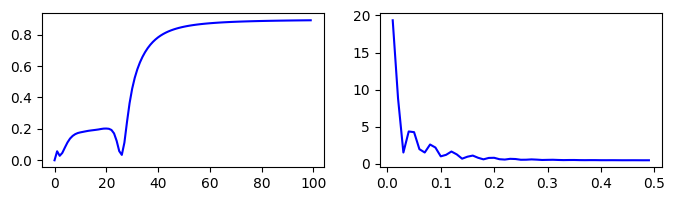

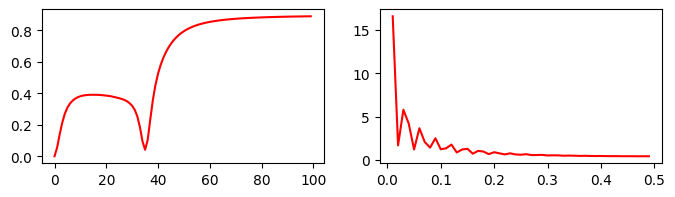

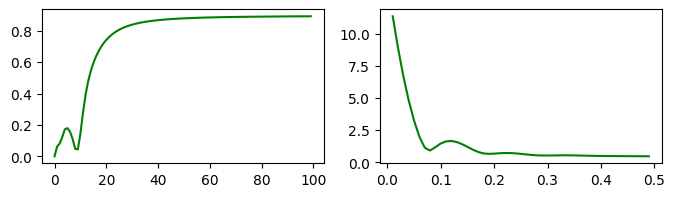

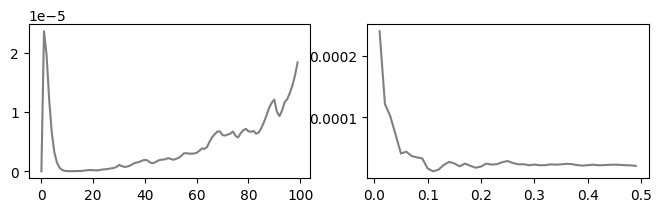

In [20]:
duration = 60
sigma=1
filename = f"DynaEnc_{duration}_{sigma10}over10.pickle"
with open(f'DynaEncResult/{filename}', mode='rb') as f:
    result = pickle.load(f)

print(result[10].fitness)
encoder_response = get_encoder_responses(perturb_inputs, 0.1, result[0])
result_arr = 0
for i in range(0,40,10):
    fig = plt.figure(figsize=(8,2))
    ax = [fig.add_subplot(1,2,ix) for ix in range(1,3)]
    ax[0].plot(encoder_response[i,],color=colors[i])
    fk = np.fft.fft(encoder_response[i,])
    N = len(encoder_response[i,])
    freq = np.fft.fftfreq(N,d=1)
    ax[1].plot(freq[1:int(N/2)],abs(fk[1:int(N/2)]),color=colors[i])
    maxval = max(encoder_response[i,])


In [416]:
# np.array(hcell_dynamics).shape

def adaptation_judge(hcell_dynamic):
    judge_err = np.zeros(Num_InputPattern)
    global_max = np.max(np.array(hcell_dynamic))
    for i in range(Num_InputPattern):
        time_course = hcell_dynamic[:,i]
        if (np.max(time_course) - time_course[-1])/global_max > 0.1:
            judge_err[i] = 1
        else:
            judge_err[i] = 0
    return judge_err

print(adaptation_judge(hcell_dynamics[0]))
dynamics_summary = [max(adaptation_judge(hcell_dynamics[cid])) for cid in range(len(hcell_dynamics))]

sum(dynamics_summary)/len(dynamics_summary)

NameError: name 'hcell_dynamics' is not defined

In [415]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



#gene_output = tc_timecourse_calc(most_fit, gene_input, test_mode = True, reft=[0,len(times)])
#print(gene_output[:,1])
gene_output = tc_fitness_calc(most_fit, gene_input, test_mode = True, reft=[0,len(times)],nvarout=0)

print("max", np.max(gene_output[:,0]))
print("end", gene_output[-1,0])

colors = ['red', 'blue', 'green', 'yellow', 'orange']

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Whole time")

# メインプロット
for i in range(Num_InputPattern*Num_NoisePattern):
    ax.plot(times, gene_output[:,i], color=colors[i % Num_InputPattern])

# インセット用の軸を追加
axins = inset_axes(ax, width="40%", height="30%", loc='right')

# インセットプロット

for i in range(Num_InputPattern*Num_NoisePattern):
    axins.plot(times[ReferenceTime[0]:ReferenceTime[1]], gene_output[ReferenceTime[0]:ReferenceTime[1], i], color=colors[i % Num_InputPattern])

# インセットの設定（オプション）
#axins.set_xlim(times[ReferenceTime[0]], times[ReferenceTime[1]])
#axins.set_ylim(np.min(gene_output[ReferenceTime[0]:ReferenceTime[1], :]), np.max(gene_output[ReferenceTime[0]:ReferenceTime[1], :]))
axins.set_ylim(np.min(gene_output[ReferenceTime[0]:ReferenceTime[1], :]), np.max(gene_output[ReferenceTime[0]:ReferenceTime[1], :]))

axins.set_xlabel("")
axins.set_title("Reference time")
axins.set_ylabel("")
ax.set_xlabel("time")
ax.set_ylabel("x")
     
plt.show()

print(gene_output)
#揺らぎのあるinputを入力. labelはある

NameError: name 'tc_fitness_calc' is not defined

true [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
pred [0 0 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1]
mutual information: 0.9869123863067224


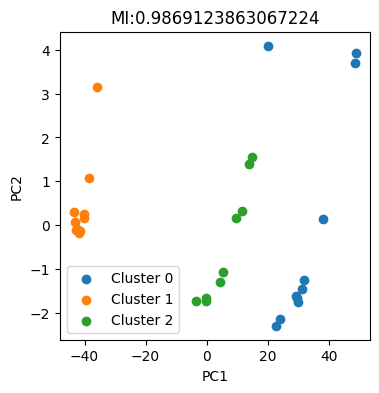

In [38]:
from sklearn.metrics import mutual_info_score

true_labels = np.tile(list(range(Num_InputPattern)),Num_NoisePattern)

X = gene_output[ReferenceTime[0]:ReferenceTime[1],:].T
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=Num_InputPattern, random_state=42)
predicted_labels = kmeans.fit_predict(X_scaled)

ami = mutual_info_score(true_labels, predicted_labels)

print("true", true_labels)
print("pred", predicted_labels)
print(f"mutual information: {ami}")
# 主成分分析 (PCA) を適用して2次元に削減
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]

# PC1とPC2の散布図をクラスターごとに色分けしてプロット
plt.figure(figsize=(4, 4))
for label in np.unique(predicted_labels):
    plt.scatter(pc1[predicted_labels == label], pc2[predicted_labels == label], label=f'Cluster {label}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'MI:{ami}')
plt.legend()

plt.show()



In [39]:
import numpy as np
from collections import Counter


# 個別のカウントを計算

print("true", true_labels)
print("pred", predicted_labels)
true_counts = Counter(true_labels)
pred_counts = Counter(predicted_labels)
joint_counts = Counter(zip(true_labels, predicted_labels))

# データのサイズ
N = len(true_labels)

# 確率分布の計算
p_true = {k: v / N for k, v in true_counts.items()}
p_pred = {k: v / N for k, v in pred_counts.items()}
p_joint = {(k1, k2): v / N for (k1, k2), v in joint_counts.items()}

print("P(true):", p_true)
print("P(pred):", p_pred)
print("P(true, pred):", p_joint)

import math

# 相互情報量の計算
mi = 0
for (x, y), p_xy in p_joint.items():
    p_x = p_true.get(x, 0)
    p_y = p_pred.get(y, 0)
    if p_x > 0 and p_y > 0:  # p(x) と p(y) がゼロでない場合
        mi += p_xy * math.log(p_xy / (p_x * p_y))

print(f"Mutual Information: {mi}")

true [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
pred [0 0 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1]
P(true): {0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}
P(pred): {0: 0.36666666666666664, 1: 0.3333333333333333, 2: 0.3}
P(true, pred): {(0, 0): 0.3333333333333333, (1, 0): 0.03333333333333333, (2, 1): 0.3333333333333333, (1, 2): 0.3}
Mutual Information: 0.9869123863067224
